# Table of contents


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import KNNImputer

#Contexto

**Swetro** es una aplicación en la que los usuarios se registran para competir en retos deportivos de running, ciclismo y caminata, ya sea para ganar premios o simplemente por el espíritu de competencia. Para participar, los usuarios registran sus actividades mediante relojes inteligentes de marcas como Garmin, Suunto, Wahoo, IgpSport, Polar y Apple Watch, o a través de las apps móviles oficiales de estas marcas desde un dispositivo móvil.

Uno de los desafíos recurrentes que enfrenta Swetro es la detección de actividades sospechosas o incoherentes, las cuales pueden surgir por diversas razones, tales como:

*   Errores en los sensores de los dispositivos, lo que genera registros  
incorrectos en métricas cómo la velocidad, distancia o ritmo cardíaco.

*  Registros humanamente imposibles, como velocidades extremas o distancias cubiertas en tiempos irrealistas.

*  Uso inadecuado del dispositivo, por ejemplo, dejarlo encendido todo el día sin realizar actividad física real.

*  Intento de fraude, donde un usuario registra una actividad pero en realidad realizó otra (ejemplo: marcar una caminata como un trote).

*  Aprovechamiento de medios externos, como subirse a un vehículo o utilizar una bicicleta eléctrica para obtener mejores tiempos y distancias.

Por lo tanto, para evitar que estas irregularidades afecten la competencia justa y la validez de los premios, es necesario desarrollar un sistema de detección de actividades atípicas o sospechosas.

Para este estudio, se utilizará un dataset de los últimos 5 meses (octubre 2024 - febrero 2025) con registros de actividades deportivas:

*  Cada fila representa una actividad registrada por un usuario.
*  Cada columna corresponde a una variable o característica de la actividad, como distancia, tiempo, velocidad promedio, ritmo cardíaco promedio, elevación ganada, etc.

Dado que las irregularidades pueden variar según la disciplina deportiva, este análisis se centrará exclusivamente en los registros de running, buscando patrones que indiquen posibles fraudes o datos erróneos.

#Descripción de los campos

Las variables que describen cada actividad son los siguientes:

*  **UserId:** Identificador único del usuario en la base de datos de la empresa.
*  **Type:** Tipo de actividad registrada (*Running, Cycling, Walking, Other*).
*  **Name:** Nombre asignado a la actividad, ya sea por el usuario o automáticamente por la aplicación.
*  **StartTimeUtc:** Fecha y hora de inicio de la actividad en UTC (*Tiempo Universal Coordinado*).
*  **DurationInSeconds:** Duración total de la actividad medida en segundos.
*  **DistanceInMeters:** Distancia recorrida durante la actividad, expresada en metros.
*  **Steps:** Número total de pasos registrados durante la actividad.
*  **AverageSpeedInMetersPerSecond:** Velocidad promedio alcanzada durante la actividad, expresada en metros por segundo.
*  **AveragePaceInMinutesPerKilometer:** Ritmo promedio de la actividad, expresado en minutos por kilómetro.
*  **TotalElevationGainInMeters:** Suma total de la elevación ganada en la actividad, expresada en metros.
*  **TotalElevationLossInMeters:** Suma total de la elevación perdida en la actividad, expresada en metros.
*  **AverageHeartRateInBeatsPerMinute:** Frecuencia cardíaca promedio durante la actividad, medida en latidos por minuto (*BPM*).
*  **SourceType:** Marca del dispositivo con el cual se registró la actividad (*Garmin, Suunto, Wahoo, IgpSports, Polar, Apple Watch*).
*  **SourceName:** Modelo del dispositivo o aplicación que registró la actividad (ejemplo: *Garmin Forerunner 945, fēnix 3 HR, etc*).
*  **Warnings:** Indicadores de posibles anomalías detectadas en la actividad. Se generan alertas en los siguientes casos:
  1.  Si la duración de la actividad es menor a 5 minutos.
  2.  Si es una actividad de ciclismo y la elevación ganada supera los 16 metros por minuto (1,000 metros por hora).
  3.  Si es una actividad de running y la elevación ganada supera los 8 metros por minuto (500 metros por hora).
  4.  Si es una actividad de running con un ritmo promedio menor a 3.5 minutos por kilómetro (3:30 min/km).
  5.  Si la actividad no registra distancia recorrida.

*  **CreationTime:** Fecha y hora en la que el registro de la actividad fue creado en la base de datos.

#Análisis exploratorio

Empezaremos por revisar la estructura del dataset, la consistencia entre los datos y que tengan el formato adecuado.



##Análisis de estructura

In [ ]:
df = pd.read_excel('./DatasetActivitiesRunning.xlsx', engine="openpyxl")
df.shape

(351195, 16)

Los datos cuentan con 351.195 observaciones y 16 columnas

In [ ]:
df.head()

,UserId,Type,Name,StartTimeUtc,DurationInSeconds,DistanceInMeters,Steps,AverageSpeedInMetersPerSecond,AveragePaceInMinutesPerKilometer,TotalElevationGainInMeters,TotalElevationLossInMeters,AverageHeartRateInBeatsPerMinute,SourceType,SourceName,Warnings,CreationTime
0,56226720,Running,Avellaneda Carrera,2024-09-30 20:36:15.0000000 +00:00,2308,6050.10,6802.0,2.622,6.356471,127.971985,128.66255,145.0,Garmin,Forerunner 35,NaN,2024-10-01 00:00:32.7421846 +00:00
1,33958672,Running,Malvinas Argentinas Carrera,2024-09-30 23:43:23.0000000 +00:00,232,557.72,600.0,2.399,6.947340,NaN,1.00000,91.0,Garmin,Forerunner 255S Music,DurationLessThanFiveMinutes,2024-10-01 00:00:37.8144259 +00:00
2,33958672,Running,Malvinas Argentinas Carrera,2024-09-30 23:53:23.0000000 +00:00,320,770.48,856.0,2.407,6.924248,3.000000,1.00000,114.0,Garmin,Forerunner 255S Music,NaN,2024-10-01 00:00:52.2962825 +00:00
3,39156304,Running,Córdoba Carrera,2024-09-30 23:26:07.0000000 +00:00,1895,5005.62,5254.0,2.642,6.308352,96.905790,107.28553,146.0,Garmin,Forerunner 45,NaN,2024-10-01 00:01:02.0718947 +00:00
4,10154408,Running,Rosario Carrera,2024-09-30 21:59:39.0000000 +00:00,4386,10376.22,11452.0,2.365,7.047216,71.099960,71.93257,143.0,Garmin,Forerunner 55,NaN,2024-10-01 00:01:30.1037912 +00:00


In [ ]:
df.isna().sum()

,0
UserId,0
Type,0
Name,0
StartTimeUtc,0
DurationInSeconds,0
DistanceInMeters,979
Steps,4008
AverageSpeedInMetersPerSecond,994
AveragePaceInMinutesPerKilometer,1052
TotalElevationGainInMeters,33316


Se puede ver que hay datos vacíos, para las variables DistanceInMeters, Steps, AverageSpeedInMetersPerSeconds, AveragePaceInMinutesPerKilometer, TotalElevationGainInMeters,TotalElevationLossInMeters, AverageHeartRateInBeatsPerMinute, SourceName y Warnings. En el proceso de limpieza se decidirá qué hacer con estas observaciones.

In [ ]:
list(df.columns)

['UserId',
 'Type',
 'Name',
 'StartTimeUtc',
 'DurationInSeconds',
 'DistanceInMeters',
 'Steps',
 'AverageSpeedInMetersPerSecond',
 'AveragePaceInMinutesPerKilometer',
 'TotalElevationGainInMeters',
 'TotalElevationLossInMeters',
 'AverageHeartRateInBeatsPerMinute',
 'SourceType',
 'SourceName',
 'Warnings',
 'CreationTime']

##Análisis de variables categóricas

Según la descripción de los campos, las siguientes variables son categoricas: SourceType, SourceName

In [ ]:
df.dtypes

,0
UserId,int64
Type,object
Name,object
StartTimeUtc,object
DurationInSeconds,int64
DistanceInMeters,float64
Steps,float64
AverageSpeedInMetersPerSecond,float64
AveragePaceInMinutesPerKilometer,float64
TotalElevationGainInMeters,float64


In [ ]:
df.describe()

,UserId,DurationInSeconds,DistanceInMeters,Steps,AverageSpeedInMetersPerSecond,AveragePaceInMinutesPerKilometer,TotalElevationGainInMeters,TotalElevationLossInMeters,AverageHeartRateInBeatsPerMinute
count,3.511950e+05,3.511950e+05,3.502160e+05,347187.000000,350201.000000,350143.000000,317879.000000,318270.000000,337981.000000
mean,4.654385e+07,2.902295e+03,7.597329e+03,7281.422167,2.775515,10.367149,130.991368,130.137395,140.610724
std,2.720984e+07,4.155384e+03,6.691007e+03,6108.132035,2.214866,420.801629,1961.576560,1972.627785,25.404904
min,2.024000e+03,-1.764163e+06,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.501057e+07,1.325000e+03,3.283648e+03,2808.000000,2.357000,5.289326,11.150000,11.000000,132.000000
50%,4.397545e+07,2.581000e+03,6.708120e+03,6568.000000,2.751000,6.057513,32.200000,32.510000,144.000000
75%,7.083190e+07,3.763000e+03,1.009291e+04,10074.000000,3.149000,7.071135,82.000000,83.829982,155.000000
max,9.799196e+07,8.019640e+05,1.148765e+06,220378.000000,997.690002,209166.666667,784072.300000,783765.800000,239.000000


In [ ]:
(df.value_counts('SourceType', normalize=True) * 100).round(2).astype(str) + '%'

,proportion
SourceType,
Garmin,91.68%
Coros,3.2%
Polar,2.74%
Wahoo,1.22%
Suunto,1.13%
Apple,0.03%


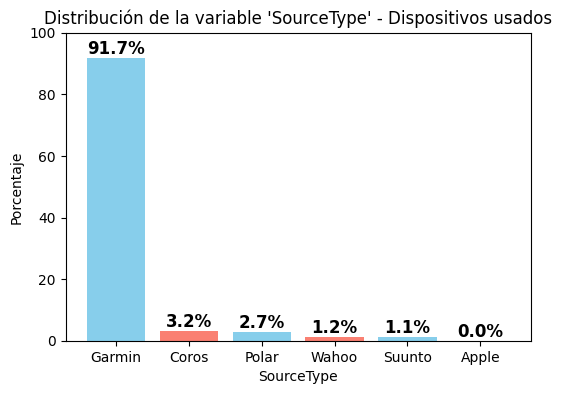

In [ ]:
porcentajes = (df.value_counts('SourceType', normalize=True) * 100).round(2)

plt.figure(figsize=(6, 4))
bars = plt.bar(porcentajes.index, porcentajes, color=['skyblue', 'salmon'])

# Agregar las etiquetas
for bar, porcentaje in zip(bars, porcentajes):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{porcentaje:.1f}%',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xlabel("SourceType")
plt.ylabel("Porcentaje")
plt.title("Distribución de la variable 'SourceType' - Dispositivos usados")
plt.ylim(0, 100)
plt.show()

Un análisis en base a las fuentes de información no es viable debido a que el dataset en este sentido está desbalanceado

In [ ]:
(df.value_counts('SourceName', normalize=True) * 100).round(2).astype(str) + '%'

,proportion
SourceName,
Forerunner 55,7.65%
Forerunner 235,5.5%
Forerunner 245 Music,4.75%
Forerunner 965,4.42%
Forerunner 45,4.06%
...,...
fenix 6S Solar,0.0%
Suunto Race S,0.0%
Wahoo ELEMNT RIVAL,0.0%


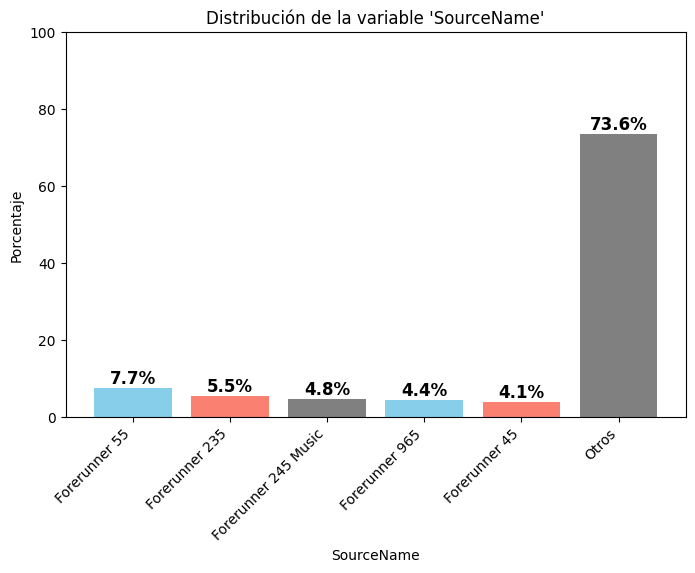

In [ ]:
porcentajes = (df.value_counts('SourceName', normalize=True) * 100).round(2)

umbral = 4
categorias_importantes = porcentajes[porcentajes >= umbral]
otros = porcentajes[porcentajes < umbral].sum()
if otros > 0:
    categorias_importantes["Otros"] = otros

plt.figure(figsize=(8, 5))
bars = plt.bar(categorias_importantes.index, categorias_importantes, color=['skyblue', 'salmon', 'gray'])

for bar, porcentaje in zip(bars, categorias_importantes):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{porcentaje:.1f}%',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xlabel("SourceName")
plt.ylabel("Porcentaje")
plt.title("Distribución de la variable 'SourceName'")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.show()

In [ ]:
# Eliminar Warnings porque puede presentarse data leakage
df = df.drop('Warnings', axis=1)

# Eliminar Type debido a que solo vamos a tomar los registros de Running por lo que solo habría una categoria en Type
df = df.drop('Type', axis=1)

# Para el startTimeUtc decidimos dividir el valor en día, fecha, año y hora
df['StartTimeUtc'] = pd.to_datetime(df['StartTimeUtc'])

df['Year'] = df['StartTimeUtc'].dt.year
df['Month'] = df['StartTimeUtc'].dt.month
df['Day'] = df['StartTimeUtc'].dt.day
df['Hour'] = df['StartTimeUtc'].dt.hour

# Además agregamos una variable adicional que represente el día de la semana en el cual realizó el ejercicio (Donde 0 es lunes, 1 es martes, etc)
df['Day_of_week'] = df['StartTimeUtc'].dt.dayofweek

# Eliminar startTimeUtc
df = df.drop('StartTimeUtc', axis=1)

# Eliminar la variable creationTime debido a que no es de valor para el análisis porque representa la fecha en la cual se registró la actividad en la base de datos
df = df.drop('CreationTime', axis=1)

# TODO: ¿Eliminar sourceName y sourceType?


##Análisis de variables enteras

In [ ]:
# Analizar duración

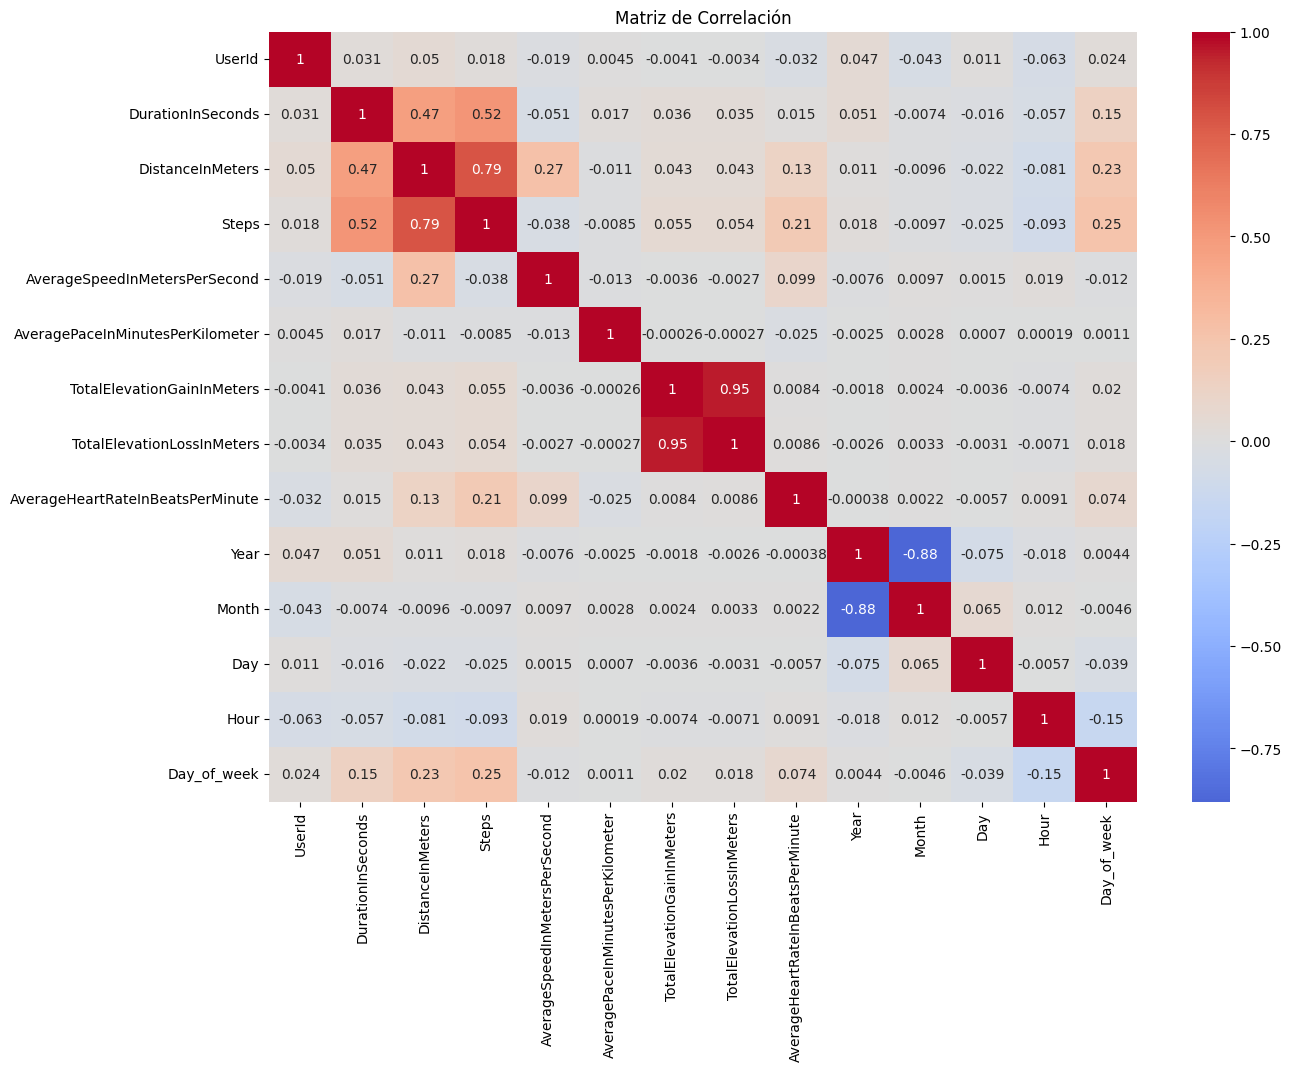

In [ ]:
# Crear matriz de correlación

df_numericas = df.select_dtypes(include=['number'])
corr_matrix = df_numericas.corr()

# Heatmap de la matriz de correlacion
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación')
plt.show()


In [ ]:
integer_columns = df.select_dtypes(include=['int64']).columns
print("Variables enteras en el dataset:", integer_columns)


Variables enteras en el dataset: Index(['UserId', 'DurationInSeconds'], dtype='object')


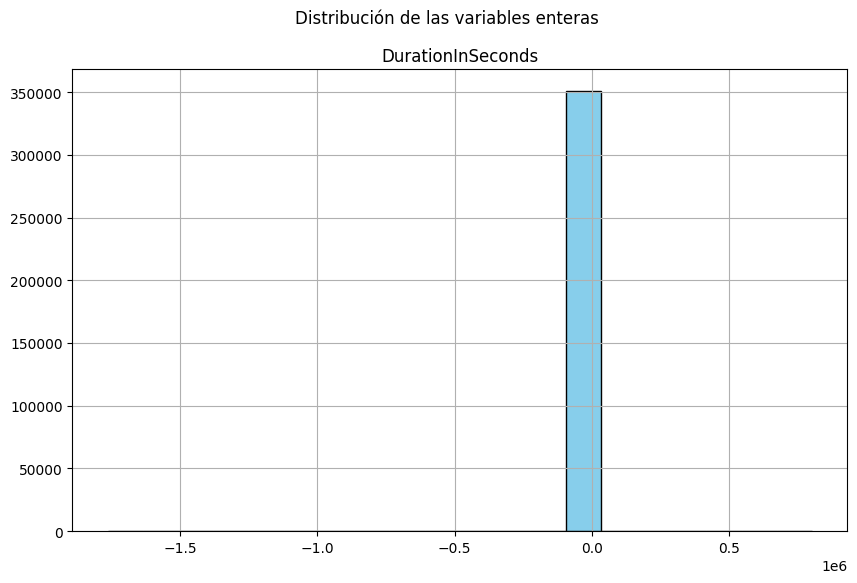

In [ ]:
integer_columns = integer_columns.drop("UserId", errors="ignore")
df[integer_columns].hist(figsize=(10, 6), bins=20, color='skyblue', edgecolor='black')
plt.suptitle("Distribución de las variables enteras")
plt.show()

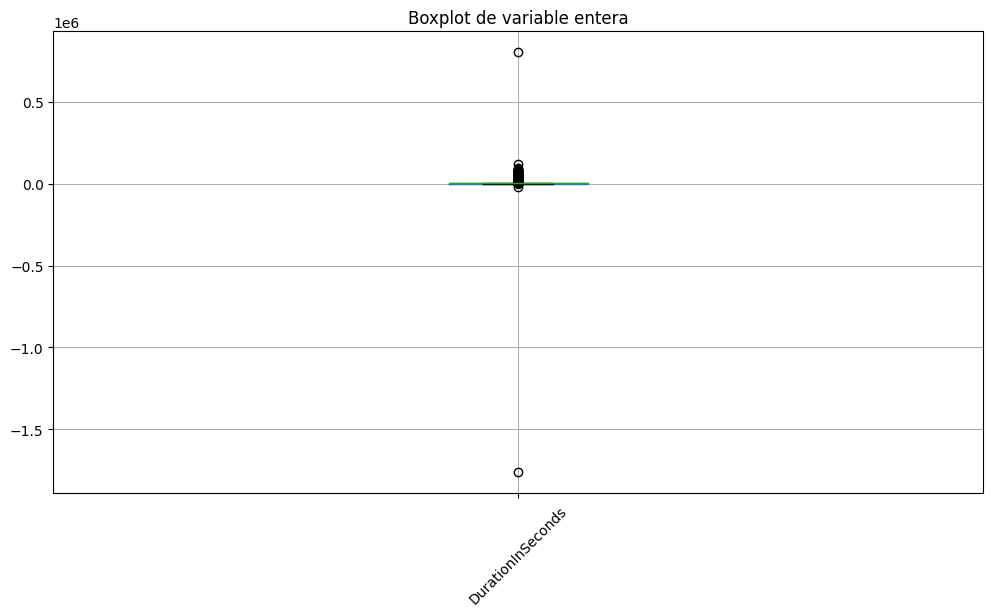

In [ ]:
plt.figure(figsize=(12, 6))
df[integer_columns].boxplot()
plt.title("Boxplot de variable entera")
plt.xticks(rotation=45)
plt.show()

##Análisis de variables continuas


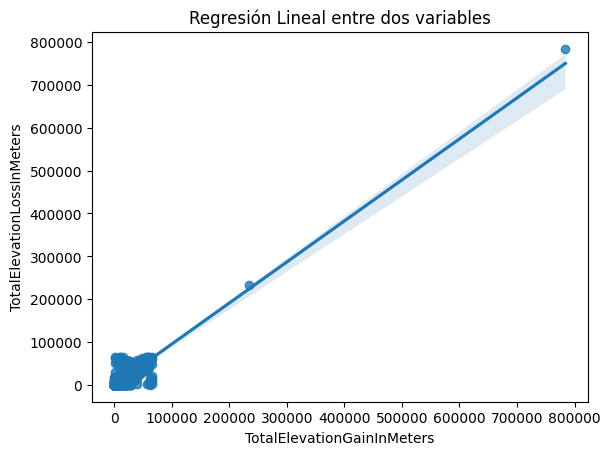

In [ ]:
# Analizar variables continuas

# Se analizará TotalElevationGainInMeters y TotalElevationLossInMeters debido a que presentan una correlación muy alta
sns.regplot(x=df["TotalElevationGainInMeters"], y=df["TotalElevationLossInMeters"])
plt.title("Regresión Lineal entre dos variables")
plt.show()


TODO: Explicar que pasa con ambas variables

In [ ]:
# Debido a que se observa un alta correlación entre ambas variables lo que nos indica que si se usan como predictoras para el modelo podemos tener problemas de colinealidad

# TODO: Explicar

df['TerrainType'] = 'Flat'  # Initialize with 'Flat'
df.loc[(df['TotalElevationGainInMeters'] > 0) & (df['TotalElevationLossInMeters'] == 0), 'TerrainType'] = 'Uphill'
df.loc[(df['TotalElevationGainInMeters'] == 0) & (df['TotalElevationLossInMeters'] > 0), 'TerrainType'] = 'Downhill'
df.loc[(df['TotalElevationGainInMeters'] > 0) & (df['TotalElevationLossInMeters'] > 0), 'TerrainType'] = 'Mixed'


 # TODO: Preguntar si al crear la columna adicional se mitiga un poco la colinealidad que se puede generar al utilizar ambas variables dentro del modelo



DistanceInMeters                                            \
                       count         mean          std  min        25%   
TerrainType                                                              
Downhill              2444.0  4417.898550  3719.049741  0.0  1313.0550   
Flat                 51443.0  2967.344868  6832.274498  0.0   390.0000   
Mixed               294229.0  8447.572280  6343.284507  0.0  4872.9500   
Uphill                2100.0  5589.930738  5179.214259  0.0  1620.1475   

                                                 DurationInSeconds  \
                     50%         75%         max             count   
TerrainType                                                          
Downhill     3447.100000   6507.5000    25013.00            2444.0   
Flat         1056.190000   4108.6900  1148765.00           52393.0   
Mixed        7510.020000  10598.1700   897198.75          294258.0   
Uphill       4844.495117   8129.6775    67343.49            2100.0   

                          ... AverageSpeedInMetersPerSecond              \
                    mean  ...                           75%         max   
TerrainType               ...                                             
Downhill     1672.906710  ...                       3.17725    8.173000   
Flat         1187.201363  ...                       3.67900  997.690002   
Mixed        3223.137821  ...                       3.10600  549.888000   
Uphill       2165.639524  ...                       3.06075   14.273000   

            AverageHeartRateInBeatsPerMinute                              \
                                       count        mean        std  min   
TerrainType                                                                
Downhill                              2436.0  137.997126  25.220774  0.0   
Flat                                 48172.0  124.689737  43.011373  0.0   
Mixed                               285293.0  143.369602  19.625354  0.0   
Uphill                                2080.0  133.987500  38.613610  0.0   

                                         
               25%    50%    75%    max  
TerrainType                              
Downhill     127.0  141.0  153.0  186.0  
Flat         118.0  136.0  150.0  239.0  
Mixed        134.0  145.0  156.0  232.0  
Uphill       126.0  144.0  155.0  198.0  

[4 rows x 32 columns]

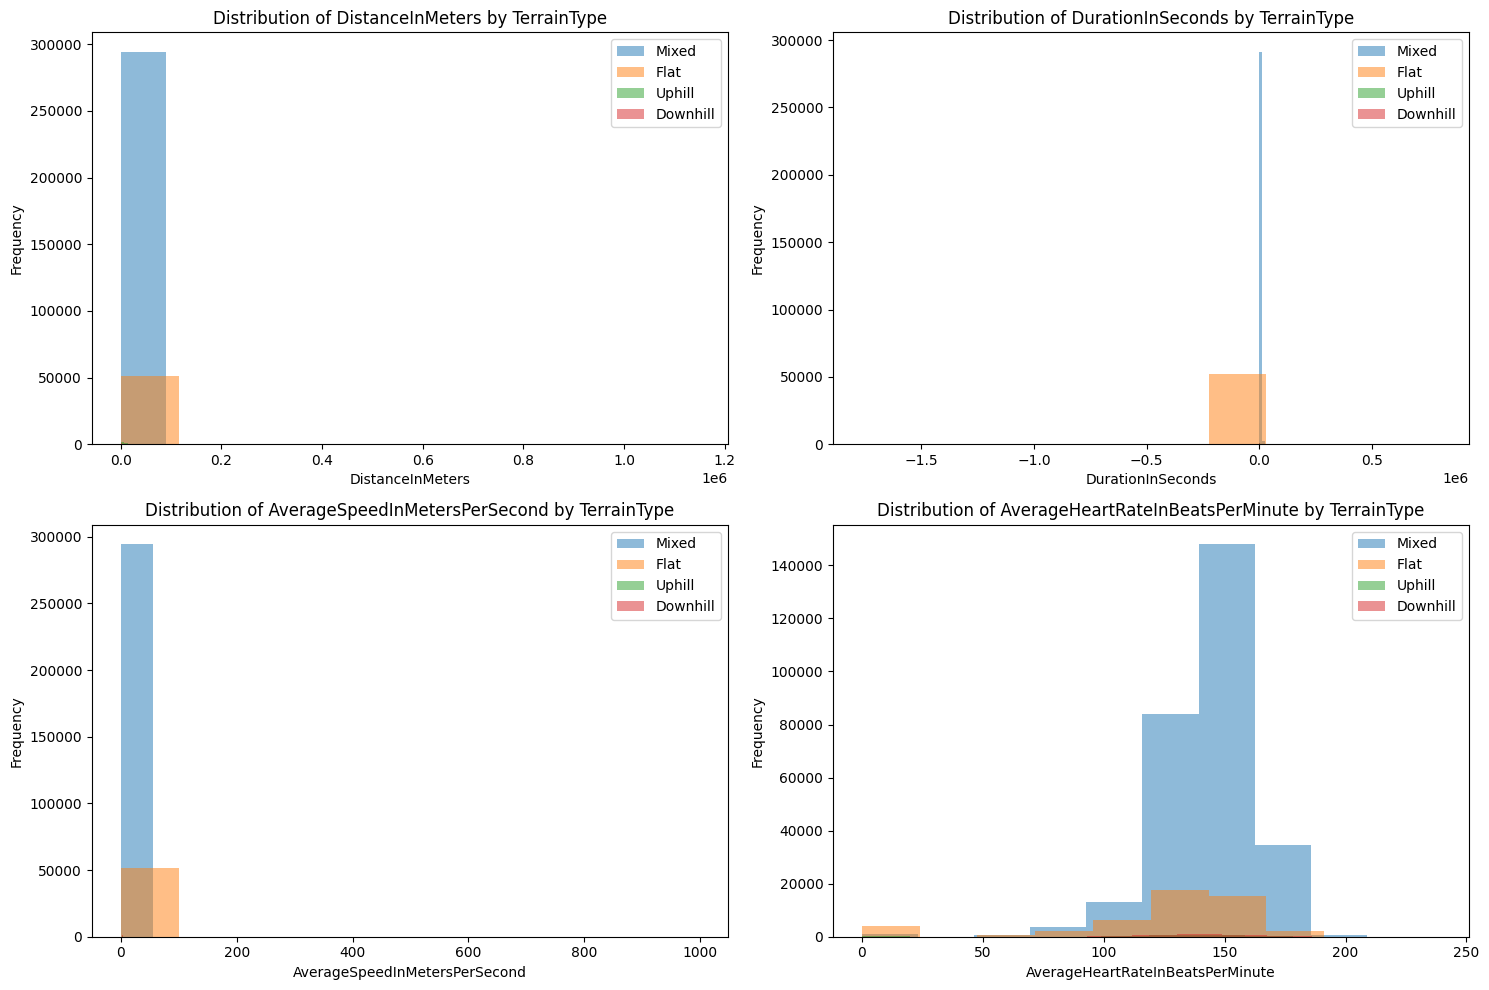

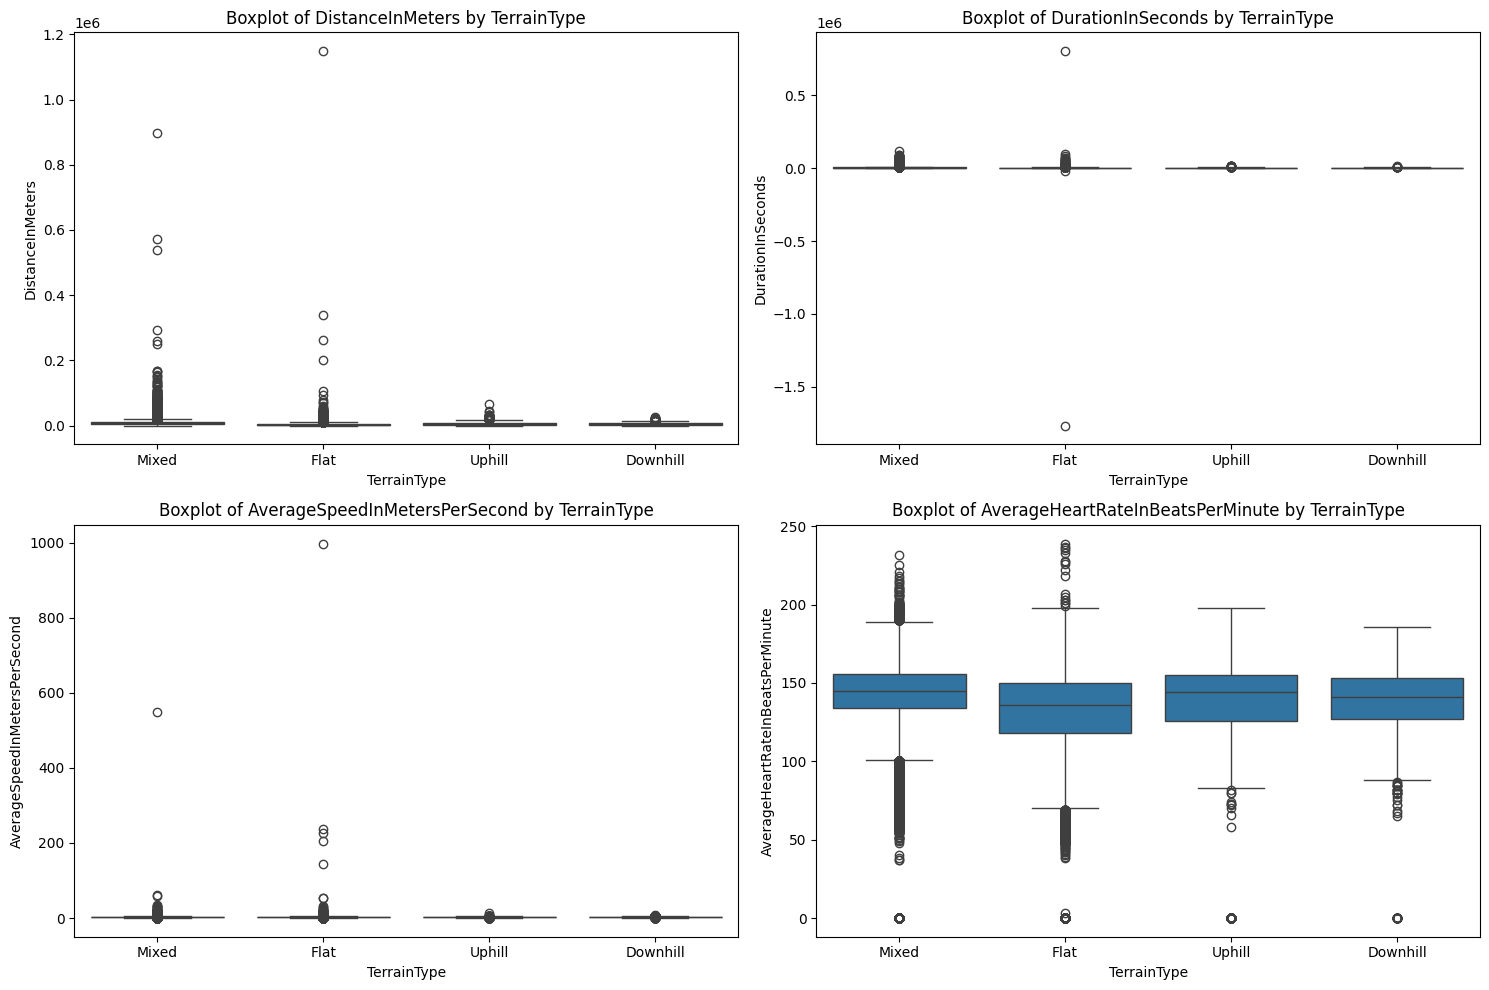

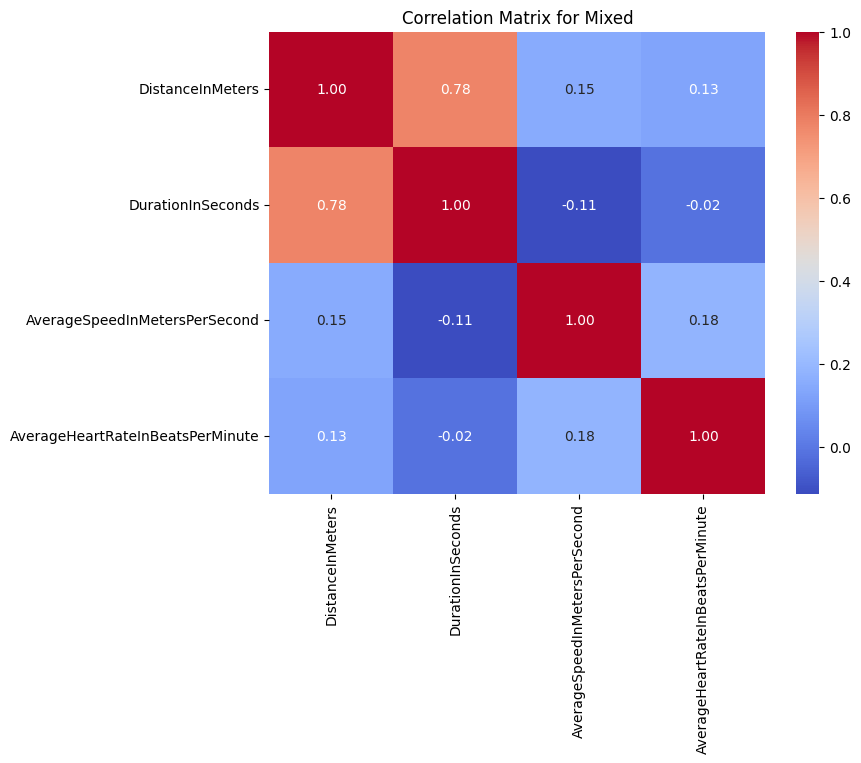

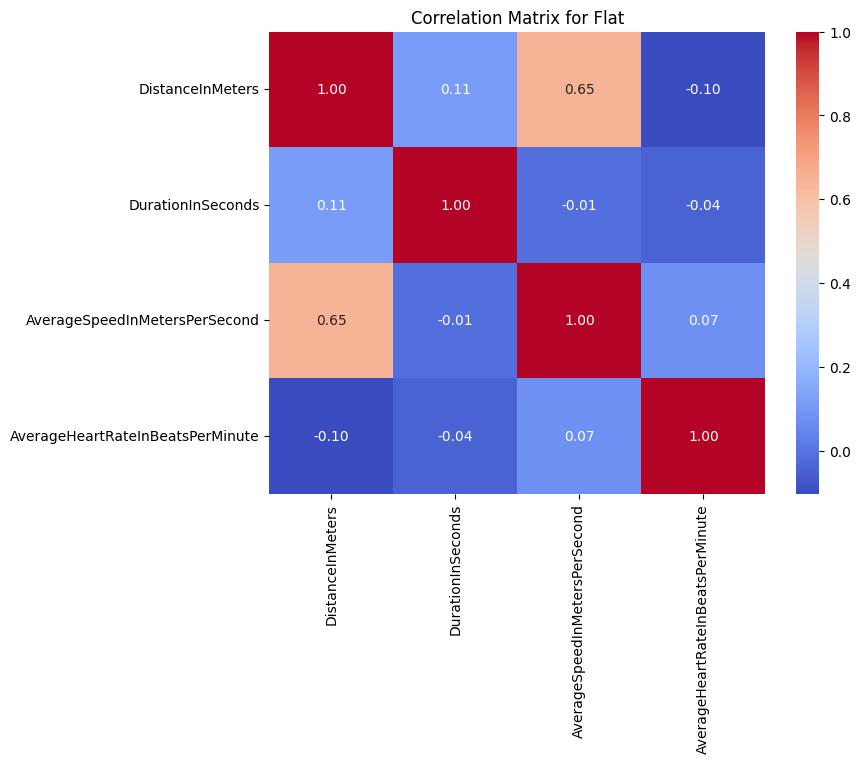

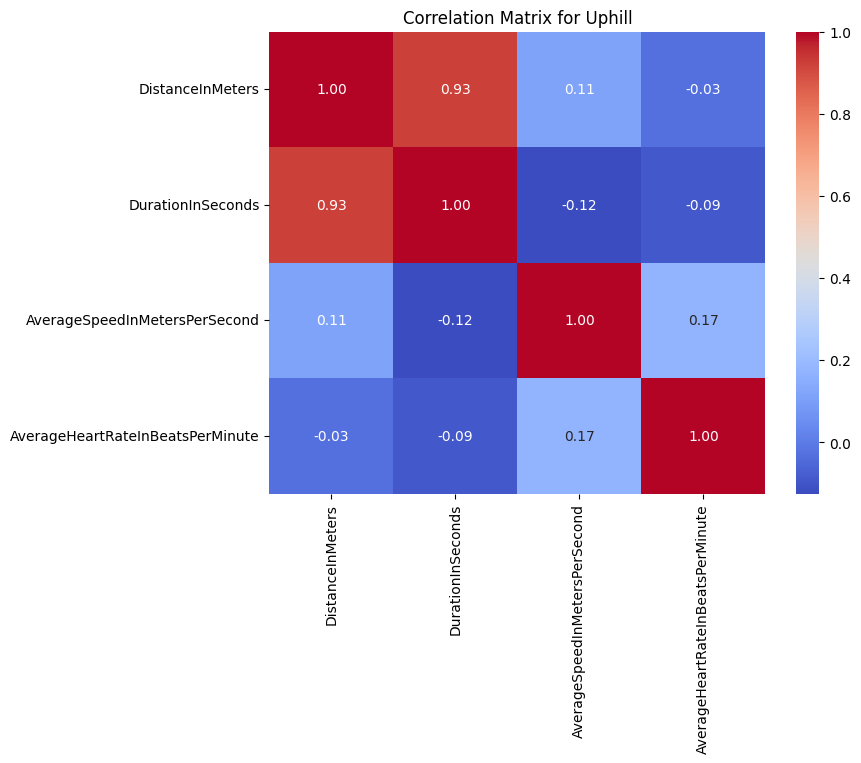

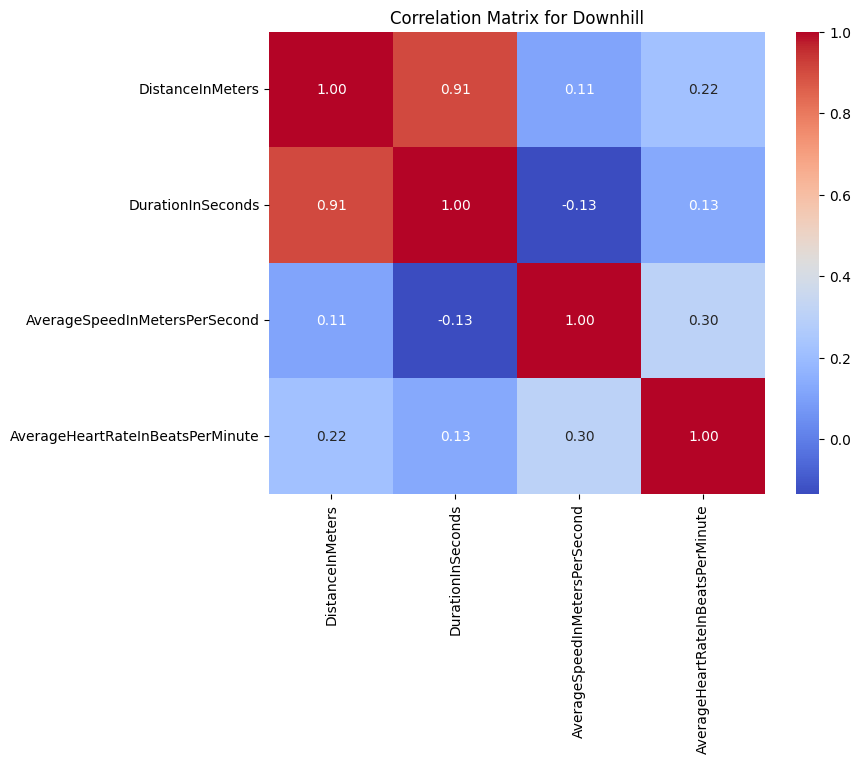

In [ ]:
# Numerical variables to analyze
numerical_cols = ['DistanceInMeters', 'DurationInSeconds', 'AverageSpeedInMetersPerSecond', 'AverageHeartRateInBeatsPerMinute']

# 1. Descriptive statistics grouped by TerrainType
descriptive_stats = df.groupby('TerrainType')[numerical_cols].describe()
display(descriptive_stats)

# 2. Visualize distributions
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 2, i + 1)
    for terrain_type in df['TerrainType'].unique():
        plt.hist(df[df['TerrainType'] == terrain_type][col].dropna(), alpha=0.5, label=terrain_type)
    plt.title(f'Distribution of {col} by TerrainType')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x='TerrainType', y=col, data=df)
    plt.title(f'Boxplot of {col} by TerrainType')
plt.tight_layout()
plt.show()

# 3. Correlation matrices and heatmaps
for terrain_type in df['TerrainType'].unique():
    terrain_data = df[df['TerrainType'] == terrain_type]
    correlation_matrix = terrain_data[numerical_cols].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Correlation Matrix for {terrain_type}')
    plt.show()

In [ ]:
print("Registros de menos de 5 minutos:",len(df[(df['DurationInSeconds']<=300)]))
durationInMinutes = df['DurationInSeconds']/60
elevationPerMinute = df['TotalElevationGainInMeters']/durationInMinutes
print('Registros con elevación ganada mayor a 8 metros por minuto:',(elevationPerMinute > 8).sum() )
print('Registros con ritmo menor a 3.5 minutos por kilometro:', ((durationInMinutes/(df['DistanceInMeters']/1000)) < 3.5).sum())
print('Registros con ritmo menor a 3.5 minutos por kilometro:',  (df['AveragePaceInMinutesPerKilometer'] < 3.5).sum())
print('Registros con distancia en 0:', (df['DistanceInMeters']==0).sum())

Registros de menos de 5 minutos: 27487
Registros con elevación ganada mayor a 8 metros por minuto: 6653
Registros con ritmo menor a 3.5 minutos por kilometro: 7727
Registros con ritmo menor a 3.5 minutos por kilometro: 8205
Registros con distancia en 0: 545


In [ ]:
# Tratamiento de duplicados
df_sin_user_id = df.drop('UserId', axis=1)
print(df_sin_user_id.index.duplicated().sum())

In [ ]:
df_sin_distancia_0 = df.dropna(subset=['DistanceInMeters'])

print(df_sin_distancia_0.isna().sum())

In [ ]:
# Tratamiento de nulos

# Eliminar registros donde la distancia es nula
df = df.dropna(subset=['DistanceInMeters'])

# Imputar valores de AverageSpeedInMeterPerSecond y AveragePaceInMinutesPerKilometer
# Se realiza el calculo manual

# Solo calcula el ritmo donde AveragePaceInMinutesPerKilometer es nulo
mask = df['AveragePaceInMinutesPerKilometer'].isna()

df.loc[mask, 'AveragePaceInMinutesPerKilometer'] = (df['DurationInSeconds'] / 60) / (df['DistanceInMeters'] / 1000)

# Solo calcula el ritmo donde AverageSpeedInMeterPerSecond es nulo
mask = df['AverageSpeedInMeterPerSecond'].isna()

df.loc[mask, 'AverageSpeedInMeterPerSecond'] = df['DistanceInMeters'] / df['DurationInSeconds']

# TODO: Que hacer con los nulos de steps, averageHeartRateInBeatsPerMinute y sourceName
# Para averageHeartRateInBeatsPerMinute imputar con valores similares (KNN)

# TODO: Preguntar si se es correcto hacer imputación de averageHeartRateInBeatsPerMinute
features = ["DistanceInMeters", "DurationInSeconds", "TotalElevationGainInMeters","TotalElevationLossInMeters", "AverageSpeedInMetersPerSecond", "AveragePaceInMinutesPerKilometer"]
df_knn = df[features]
imputer = KNNImputer(n_neighbors=5)
df_knn["averageHeartRateInBeatsPerMinute"] = imputer.fit_transform(df_knn)[
    :, df_knn.columns.get_loc("averageHeartRateInBeatsPerMinute")
]
df['averageHeartRateInBeatsPerMinute'] = df_knn['averageHeartRateInBeatsPerMinute']


###Analisis de outliers


* DistanceInMeters: Distancia recorrida durante la actividad, expresada en metros.
* AverageHeartRateInBeatsPerMinute: Frecuencia cardíaca promedio durante la actividad, medida en latidos por minuto (BPM).
* AveragePaceInMinutesPerKilometer: Ritmo promedio de la actividad, expresado en minutos por kilómetro.


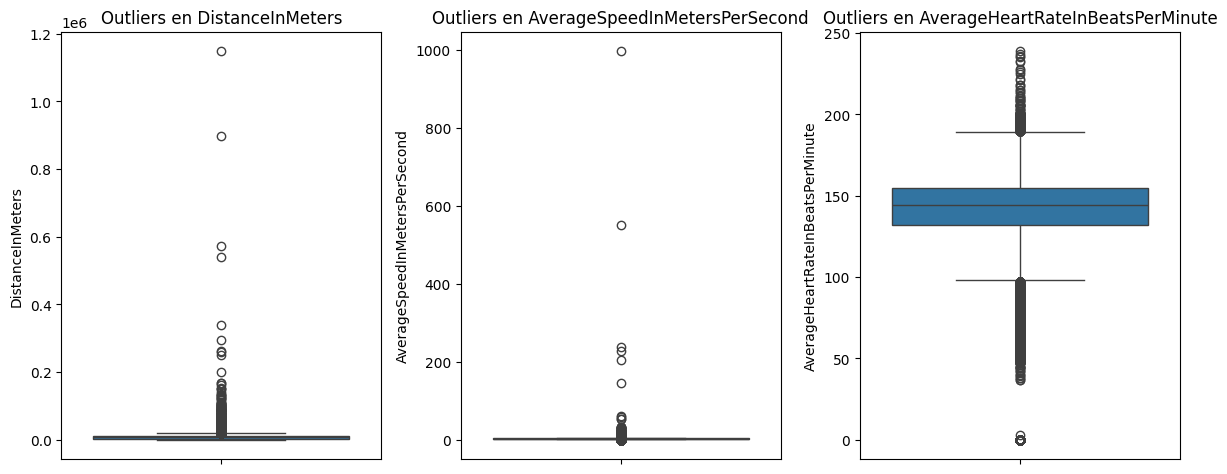

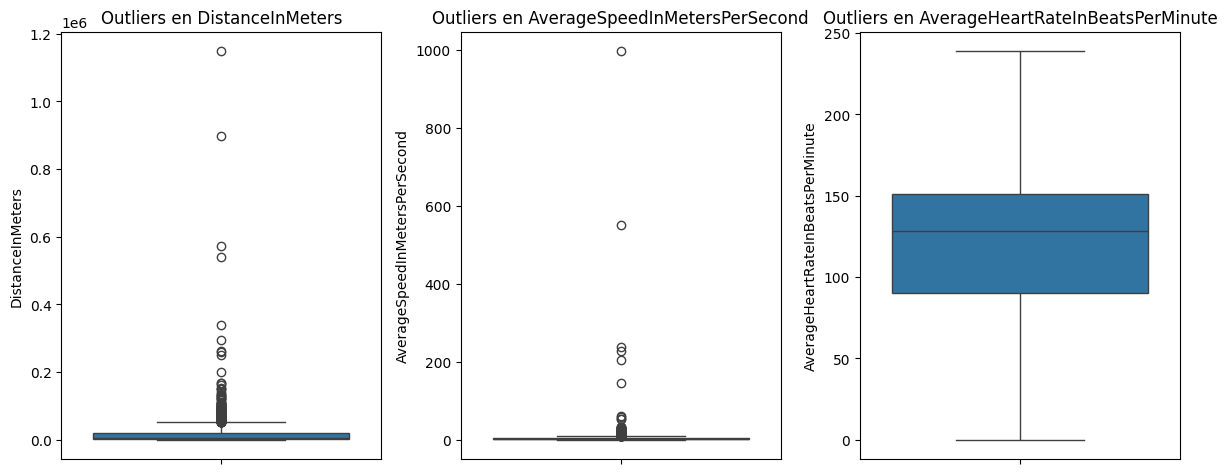

In [ ]:
outlier_cols = ["DistanceInMeters", "AverageSpeedInMetersPerSecond", "AverageHeartRateInBeatsPerMinute"]

plt.figure(figsize=(12, 5))
for i, col in enumerate(outlier_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f"Outliers en {col}")
plt.tight_layout()
plt.show()

# Detección de outliers con el método IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Crear boxplots solo con los outliers
df_outliers = pd.DataFrame()
for col in outlier_cols:
    df_outliers = pd.concat([df_outliers, detect_outliers_iqr(df, col)])

df_outliers = df_outliers.drop_duplicates()

plt.figure(figsize=(12, 5))
for i, col in enumerate(outlier_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df_outliers[col])
    plt.title(f"Outliers en {col}")
plt.tight_layout()
plt.show()

**Conclusiones Outliers**

TODO

#Limpieza de datos


Ahora empezaremos a crear reglas para la limpieza de datos, para esto debemos dividir los datos en set de entrenamiento y set de validación y set de prueba.

##Division de datasets


##Imputación


#Feature Engineering


##Dummificar variables
